# Background
This file contains the code that were used to analyze the trend of temperature trend analysis of Koshi Basin for the paper that was submited to SOHAM.

First of all data were collected from Department of Hydrology Nepal for the koshi basin of all available stations and arranged in a single `csv` file.

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import pykrige
import statsmodels.api as sm
from geopandas.tools import sjoin
import seaborn as sns
import pandas as pd
import scipy.stats 
import pymannkendall as mk
import matplotlib.pyplot as plt
from pykrige.ok import OrdinaryKriging
from shapely.geometry import Point
from matplotlib_scalebar.scalebar import ScaleBar
from matplotlib.offsetbox import AnchoredOffsetbox, TextArea, DrawingArea, OffsetBox
import contextily as cx
from eomaps import Maps
import matplotlib.patches as mpatches
from scipy.stats import linregress
import numpy as np
import pandas as pd
import geopandas as gpd
from pykrige.ok import OrdinaryKriging
import matplotlib.pyplot as plt
from shapely.geometry import Point

### Preparation of shape file
Koshi basin for the study area is prepared based on the putting outlet point at chatara sunsari.

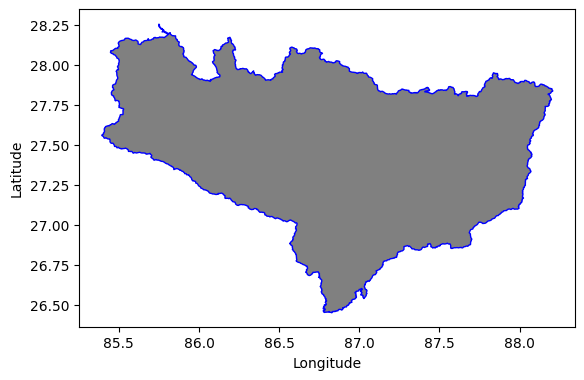

In [ ]:
shapefile_path1 = r"G:\fresh_start\paper\code_paper\arcgis\base_gis_data\Koshi_Boundary.shp"

shapefile_path2 = r"G:\fresh_start\paper\code_paper\arcgis\base_gis_data\Saptaei_Boundary.shp"
# Reading shapefiles

gdf1 = gpd.read_file(shapefile_path1)
gdf2 = gpd.read_file(shapefile_path2)
# Concatenate (combine) the shapefiles
combined_shapefile = gpd.GeoDataFrame(pd.concat([gdf1, gdf2], ignore_index=True))
combined_shapefile['poly_name'] = 'Basin'
combine_polygon = combined_shapefile[combined_shapefile['poly_name']=='Basin']
combined_basin = combine_polygon.dissolve(by='poly_name')

# viewing the prepared shape file
fig, ax = plt.subplots()
combined_basin.plot(ax=ax, facecolor='gray', edgecolor='blue')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
# Set the aspect ratio manually to a finite positive value
ax.set_aspect('equal')  # or any other suitable aspect ratio
plt.show()

<Axes: >

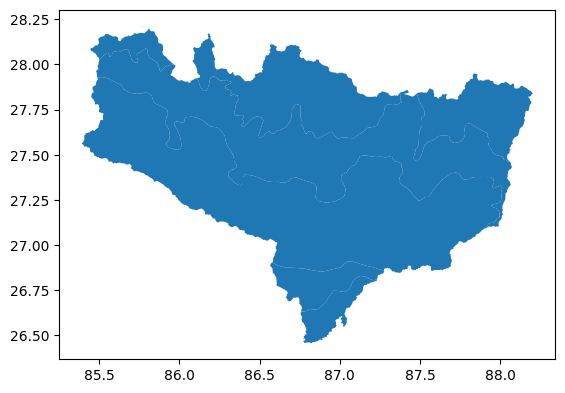

In [ ]:
# Load the Nepal and Koshi basin shapefiles
nepal_shapefile_path = r'G:\fresh_start\paper\code_paper\arcgis\whole_nepal\Physiography\Physiography_Nepal.shp'
gdf_nepal = gpd.read_file(nepal_shapefile_path)
gdf_koshi_basin  = combined_basin.copy()
# Ensure both GeoDataFrames have the same CRS (Coordinate Reference System)
if gdf_nepal.crs != gdf_koshi_basin.crs:
    gdf_koshi_basin = gdf_koshi_basin.to_crs(gdf_nepal.crs)

# Perform spatial intersection to get the part of Nepal within the Koshi Basin
gdf_nepal_in_koshi = gpd.overlay(gdf_nepal, gdf_koshi_basin, how='intersection')
gdf_nepal_in_koshi.plot()

### Staion list
Preparing station details that were taken for data analysis

In [ ]:
# Importing obtained data from DHM
stn_df = pd.read_csv(r"G:\fresh_start\paper\code_paper\main_data\final_data\daily_avg_1962.csv")
# Importing all station  data from DHM
all_npl_stn_list = pd.read_excel(r"G:\fresh_start\paper\code_paper\main_data\raw_data\Meteorological_station_list.xlsx")
all_npl_stn_list = all_npl_stn_list.rename(columns={"Index No.": "station"})
# Extract unique stations with regions, latitude, longitude, and elevation
unique_stations = stn_df[['station', 'regions', 'lat', 'long', 'elevation']].drop_duplicates()

# Display the unique station info
filtered_data = pd.merge(unique_stations, all_npl_stn_list, on='station', how='left')

selected_columns = ['station','Station Name', 'regions', 'lat', 'long', 'elevation']
filtered_data = filtered_data[selected_columns]
# There is one station with no staion number thats why it was replaced by 9999 as station number

filtered_data.loc[filtered_data['station'] == 9999, 'Station Name' ] = 'Lubuche'
#filtered_data.to_csv(r"G:\fresh_start\paper\code_paper\main_data\final_data\final_stations_koshi.csv", index=False)


In [ ]:
stations = filtered_data.copy()
# Create a GeoDataFrame
geometry = [Point(xy) for xy in zip(stations['long'], stations['lat'])]
gdf_stations = gpd.GeoDataFrame(stations, geometry=geometry)

# Set coordinate reference system (CRS) if known; otherwise, default is EPSG:4326
gdf_stations.crs = "EPSG:4326"

In [ ]:
stations_table = stations.copy()
stations_table['regions'] = stations_table['regions'].replace({
    'High Mountain': 'Himalaya',
    'Middle Mountain': 'High Mountain',
    'Hill': 'Middle Mountain'
})
region_mapping = {
    'Tarai': 'TAR',
    'Himalaya': 'H',
    'Middle Mountain': 'MM',
    'High Mountain': 'HM',
    'Siwalik': 'SW'
}
stations_table['Physiographic Regions'] = stations_table['regions'].map(region_mapping)

# Rearrange columns as per the desired format
stations_table = stations_table[['station', 'Station Name', 'lat', 'long', 'elevation', 'Physiographic Regions']]

# Rename columns
stations_table.columns = ['Station No.', 'Station Name', 'Latitude (°N)', 'Longitude (°E)', 'Elevation (m)', 'Physiographic Regions']

# Display the formatted table
print(stations_table)

    Station No.        Station Name  Latitude (°N)  Longitude (°E)  \
0          1316             Chatara      26.820440       87.159170   
1          1201        Namche Bazar      27.816670       86.716670   
2          1401        Olangchuhg G      27.683330       87.783330   
3          1225          Syangboche      27.816670       86.716670   
4          1218           Tengboche      27.833330       86.766670   
5          1206         Okhaldhunga      27.308121       86.504225   
6          1405           Taplejung      27.358611       87.670000   
7          1103                Jiri      27.630447       86.232114   
8          1036           Panchkhal      27.645134       85.620881   
9          1016          Sarmathang      27.944561       85.595136   
10         1123            Manthali      27.394703       86.061233   
11         1124               Kabre      27.633333       86.133333   
12         1212            Phatepur      26.730538       86.934812   
13         1219     

In [ ]:
gdf_basin = gdf_nepal_in_koshi.copy()

# Rename the column 'DESCRIPTIO' to 'DESCRIPTION'
gdf_basin = gdf_basin.rename(columns={'DESCRIPTIO': 'DESCRIPTION'})
# Replace values in the 'DESCRIPTION' column
gdf_basin['DESCRIPTION'] = gdf_basin['DESCRIPTION'].replace({
    'High Mountain': 'Himalaya',
    'Middle Mountain': 'High Mountain',
    'Hill': 'Middle Mountain'
})

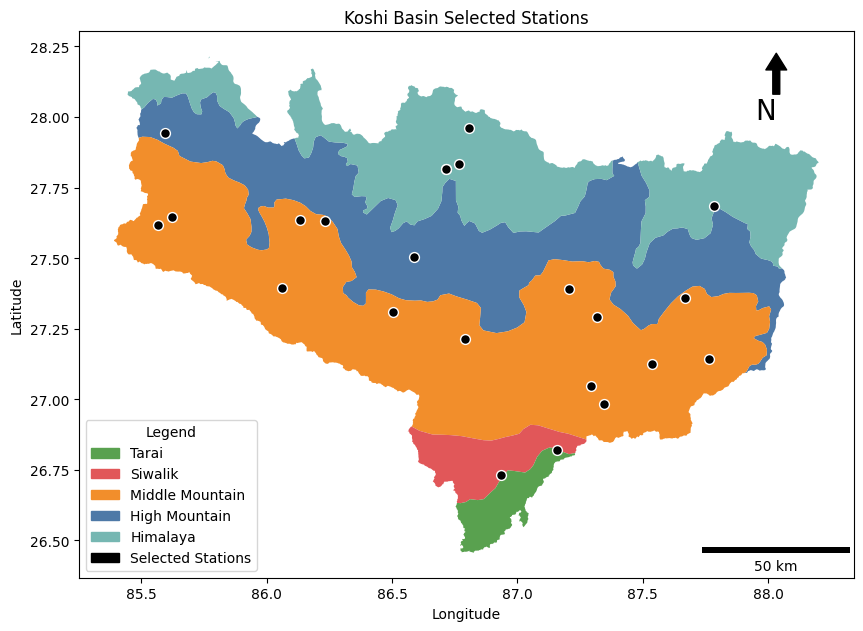

In [ ]:

# Step 4: Plot the data
fig, ax = plt.subplots(figsize=(10, 10), alpha = 0.5, edgecolor = "k")

color_map = {
    'Tarai': '#59A14F',            # Natural Green
    'Siwalik': '#E15759',          # Soft Red
    'Middle Mountain': '#F28E2B',             # Warm Orange
    'High Mountain': '#4E79A7',  # Soft Blue
    'Himalaya': '#76B7B2',    # Gentle Teal
    
}

for regions, data in gdf_basin.groupby('DESCRIPTION'):
    color = color_map[regions]
    data.plot(
        color=color,
        ax=ax,
        )


# Plot the stations
gdf_stations.plot(ax=ax, color='black', markersize=50, edgecolor='white', label='Selected Stations')
# Add legend


# Add titles and labels
ax.set_title('Koshi Basin Selected Stations')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')


# Add a scale bar

points = gpd.GeoSeries(
    [Point(-73.5, 40.5), Point(-74.5, 40.5)], crs=4326
)  # Geographic WGS 84 - degrees
points = points.to_crs(32619)
distance_meters = points[0].distance(points[1])
ax.add_artist(ScaleBar((distance_meters), location ="lower right"))


x, y, arrow_length = 0.9, 0.96, 0.08
ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', width=5, headwidth=15),
            ha='right', va='top', fontsize=20,
            xycoords=ax.transAxes)


# Step 2: Create custom legend handles for the regions and stations

# Handles for the regions
legend_handles_regions = [mpatches.Patch(color=color, label=region) for region, color in color_map.items()]

# Handle for the stations
legend_handle_stations = mpatches.Patch(color='black', label='Selected Stations')

# Combine both sets of handles
all_legend_handles = legend_handles_regions + [legend_handle_stations]

# Add the combined legend
ax.legend(handles=all_legend_handles, title="Legend", loc='lower left', bbox_to_anchor=(0, 0))

ax.grid(False)

#plt.savefig(r"G:\fresh_start\paper\code_paper\plots\study_area\koshi_basin_selected_station_study_area_map.png", dpi=1500, bbox_inches='tight')
# Show plot
plt.show()

# Results 
This section focus on preparation of data for results lets first clean the data.

In [ ]:
for_nan_fill_df = pd.read_csv(r'G:\fresh_start\paper\code_paper\main_data\raw_data\df33333333_Nan.csv')

for_nan_fill_df['date'] = pd.to_datetime(for_nan_fill_df['date'])
print(for_nan_fill_df)

             date  station        regions        lat       long  elevation  \
0      1962-01-01     1316          Tarai  26.820440  87.159170      105.0   
1      1962-01-02     1316          Tarai  26.820440  87.159170      105.0   
2      1962-01-03     1316          Tarai  26.820440  87.159170      105.0   
3      1962-01-04     1316          Tarai  26.820440  87.159170      105.0   
4      1962-01-05     1316          Tarai  26.820440  87.159170      105.0   
...           ...      ...            ...        ...        ...        ...   
512534 2022-12-27     9999  High Mountain  27.961111  86.808889     5200.0   
512535 2022-12-28     9999  High Mountain  27.961111  86.808889     5200.0   
512536 2022-12-29     9999  High Mountain  27.961111  86.808889     5200.0   
512537 2022-12-30     9999  High Mountain  27.961111  86.808889     5200.0   
512538 2022-12-31     9999  High Mountain  27.961111  86.808889     5200.0   

             Tmin      Tmax  
0             NaN       NaN  
1  

In [ ]:

df11_merged = for_nan_fill_df.copy()  

# List of unique stations
stations = df11_merged['station'].unique()

# Function to calculate IQR and replace outliers with NaN
def replace_outliers_with_nan(data, column):
    Q1 = data[column].quantile(0.25)  # 25th percentile
    Q3 = data[column].quantile(0.75)  # 75th percentile
    IQR = Q3 - Q1  # Interquartile Range
    lower_bound = Q1 - 1.5 * IQR  # Lower bound
    upper_bound = Q3 + 1.5 * IQR  # Upper bound

    # Replace values outside the bounds with NaN, keeping original NaN values
    data.loc[:,column] = data[column].where((data[column].isna()) | 
                                      ((data[column] >= lower_bound) & (data[column] <= upper_bound)), 
                                      other=pd.NA)
    return data

# Iterate over each station and apply outlier replacement for Tmin and Tmax
for station in stations:
    # Filter data for the current station
    station_data = df11_merged[df11_merged['station'] == station]
    
    # Apply the outlier replacement for both Tmin and Tmax columns
    station_data = replace_outliers_with_nan(station_data, 'Tmin')
    station_data = replace_outliers_with_nan(station_data, 'Tmax')
    
    # Update the original dataframe with the filtered station data
    df11_merged.loc[df11_merged['station'] == station] = station_data

# Reset the index if needed
df11_merged.reset_index(drop=True, inplace=True)



### Lapse rate Equation

$$ T_{cal} = T_{obs} + (H_{Elevation} - L_{Elevation}) * (-0.0065) $$

**Where,** 

$ T_{cal} $ = High elevation calculating temperature\
$ T_{obs} $ = Low elevation observed temperature\
$ H_{Elevation} $ = High elevation (calculating temperature station's elevation)\
$ L_{Elevation} $ = Low elevation (observed temperature station's elevation)\




In [ ]:
def calculate_temp(row, temp_column, df):
    if pd.isna(row[temp_column]):  # If the temperature (e.g., Tmin) is NaN
        # Filter the data for the same date and valid temperature values
        same_date_data = df[(df['date'] == row['date']) & ~pd.isna(df[temp_column])]
        
        if not same_date_data.empty:
            # Calculate the average temperature of available stations
            avg_temp = same_date_data[temp_column].mean()
            
            # Calculate the average elevation difference
            avg_elevation_diff = (same_date_data['elevation'] - row['elevation']).mean()
            
            # Apply the lapse rate adjustment using the average elevation difference
            lapse_rate = -6.5 / 1000  # Lapse rate in °C per meter
            adjusted_temp = avg_temp + avg_elevation_diff * lapse_rate
            
            return adjusted_temp  # Return the adjusted temperature
        
    return row[temp_column]  # If temperature is not NaN, return the original value

In [ ]:
df11_merged['date'] = pd.to_datetime(df11_merged['date'])
print(df11_merged)



             date  station        regions        lat       long  elevation  \
0      1962-01-01     1316          Tarai  26.820440  87.159170      105.0   
1      1962-01-02     1316          Tarai  26.820440  87.159170      105.0   
2      1962-01-03     1316          Tarai  26.820440  87.159170      105.0   
3      1962-01-04     1316          Tarai  26.820440  87.159170      105.0   
4      1962-01-05     1316          Tarai  26.820440  87.159170      105.0   
...           ...      ...            ...        ...        ...        ...   
512534 2022-12-27     9999  High Mountain  27.961111  86.808889     5200.0   
512535 2022-12-28     9999  High Mountain  27.961111  86.808889     5200.0   
512536 2022-12-29     9999  High Mountain  27.961111  86.808889     5200.0   
512537 2022-12-30     9999  High Mountain  27.961111  86.808889     5200.0   
512538 2022-12-31     9999  High Mountain  27.961111  86.808889     5200.0   

             Tmin      Tmax  
0             NaN       NaN  
1  

In [ ]:
df11_merged['Tmin'] = df11_merged.apply(lambda row: calculate_temp(row, 'Tmin', df11_merged), axis=1)
df11_merged['Tmax'] = df11_merged.apply(lambda row: calculate_temp(row, 'Tmax', df11_merged), axis=1)
print(df11_merged)

             date  station        regions        lat       long  elevation  \
0      1962-01-01     1316          Tarai  26.820440  87.159170      105.0   
1      1962-01-02     1316          Tarai  26.820440  87.159170      105.0   
2      1962-01-03     1316          Tarai  26.820440  87.159170      105.0   
3      1962-01-04     1316          Tarai  26.820440  87.159170      105.0   
4      1962-01-05     1316          Tarai  26.820440  87.159170      105.0   
...           ...      ...            ...        ...        ...        ...   
512534 2022-12-27     9999  High Mountain  27.961111  86.808889     5200.0   
512535 2022-12-28     9999  High Mountain  27.961111  86.808889     5200.0   
512536 2022-12-29     9999  High Mountain  27.961111  86.808889     5200.0   
512537 2022-12-30     9999  High Mountain  27.961111  86.808889     5200.0   
512538 2022-12-31     9999  High Mountain  27.961111  86.808889     5200.0   

             Tmin      Tmax  
0      -20.794283 -8.535149  
1  

In [ ]:
data_import = df11_merged.copy()

In [ ]:
data_import["Tavg"] = (data_import['Tmax']+data_import["Tmin"])/2
data_import['date'] = pd.to_datetime(data_import['date'])
data_import['year'] = data_import['date'].dt.year

Data is cleaned now do some analysis

In [4]:
stations_info = pd.read_csv(r"G:\fresh_start\paper\code_paper\main_data\final_data\final_stations_koshi.csv")
trend_data = pd.read_csv(r"G:\fresh_start\paper\code_paper\results\slr_n_mk_test\stations_avg_slr_slope_results_df.csv")
# Merging the two DataFrames on the 'station' column
combined_data = pd.merge(stations_info, trend_data[['station', 'slope_Tmin', 'slope_Tmax', 'slope_Tavg']], on='station', how='inner')

shapefile_path = r'G:\fresh_start\paper\code_paper\arcgis\koshibasin\physiographic_koshi\koshi_5_physiographic.shp'
boundary_gdf  = gpd.read_file(shapefile_path)

C:\Users\Administrator\AppData\Local\Temp\ipykernel_1408\2490953432.py:29: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  boundary_polygon = boundary_gdf.unary_union  # Combine all boundary shapes into one


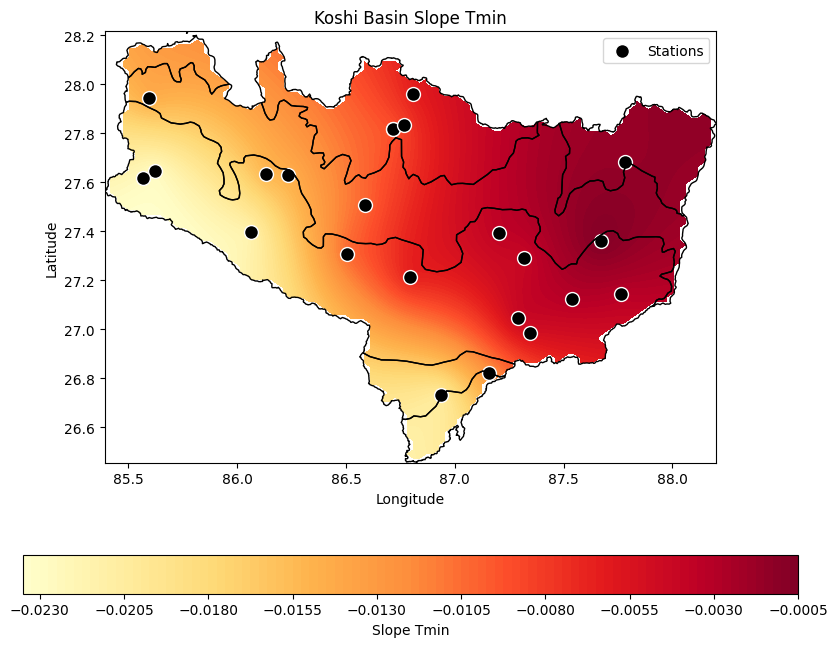

C:\Users\Administrator\AppData\Local\Temp\ipykernel_1408\2490953432.py:29: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  boundary_polygon = boundary_gdf.unary_union  # Combine all boundary shapes into one


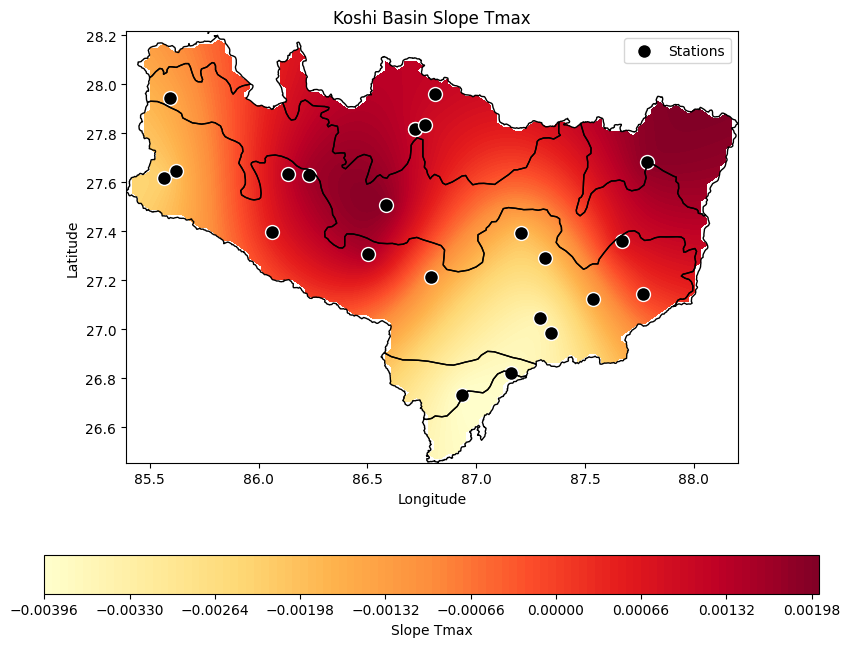

C:\Users\Administrator\AppData\Local\Temp\ipykernel_1408\2490953432.py:29: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  boundary_polygon = boundary_gdf.unary_union  # Combine all boundary shapes into one


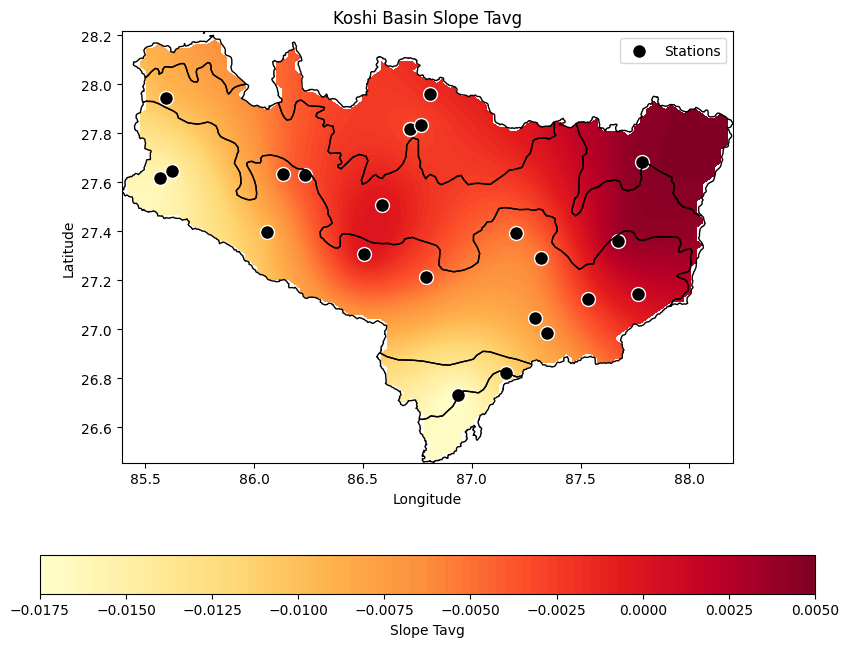

In [6]:
slope_columns = ['slope_Tmin', 'slope_Tmax', 'slope_Tavg']
titles = ['Koshi Basin Slope Tmin', 'Koshi Basin Slope Tmax', 'Koshi Basin Slope Tavg']
colorbar_labels = ['Slope Tmin', 'Slope Tmax', 'Slope Tavg']

# Loop through the slope columns and create a plot for each
for i, col in enumerate(slope_columns):
    # Extract data for interpolation
    values = combined_data[col].values
    coords = np.array(list(zip(combined_data['long'], combined_data['lat'])))
    
    # Define grid based on boundary file
    minx, miny, maxx, maxy = boundary_gdf.total_bounds
    gridx = np.linspace(minx, maxx, 100)
    gridy = np.linspace(miny, maxy, 100)

    # Perform Ordinary Kriging
    OK = OrdinaryKriging(
        combined_data['long'], combined_data['lat'], values,
        variogram_model='linear', verbose=False, enable_plotting=False
    )

    # Interpolate values over the grid
    z, ss = OK.execute('grid', gridx, gridy)

    # Create a meshgrid for plotting
    X, Y = np.meshgrid(gridx, gridy)

    # Mask values outside the boundary
    boundary_polygon = boundary_gdf.unary_union  # Combine all boundary shapes into one
    mask = np.array([[boundary_polygon.contains(Point(x, y)) for x in gridx] for y in gridy])

    # Apply the mask to the interpolated values (keep only inside the boundary)
    z_masked = np.ma.masked_where(~mask, z)

    # Plot the masked interpolation inside the boundary
    plt.figure(figsize=(10, 8))
    contour = plt.contourf(X, Y, z_masked, cmap='YlOrRd', levels=100)  # Use grayscale colormap
    boundary_gdf.boundary.plot(ax=plt.gca(), color='black', linewidth=1)

    # Add station points with white borders
    plt.scatter(combined_data['long'], combined_data['lat'], facecolors='black', edgecolors='white', marker='o', s=100, label='Stations')

    # Add labels and title
    plt.title(titles[i])
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')

    # Horizontal colorbar
    cbar = plt.colorbar(contour, orientation='horizontal')
    cbar.set_label(colorbar_labels[i])

    # Show legend
    plt.legend()
    # Display the plot
    plt.show()

# initial

In [ ]:


input_csv = pd.read_csv(r"G:\fresh_start\paper\code_paper\main_data\final_data\decadal_trend_data.csv")

# Strip any extra spaces
input_csv['naming'] = input_csv['naming'].str.strip()

# Split the string by spaces, and assign accordingly
input_csv['Temperature_Type'] = input_csv['naming'].str.split().str[0]  # First word
input_csv['Season'] = input_csv['naming'].str.split().str[-1]  # Last word
input_csv['Region'] = input_csv['naming'].str.split().str[1:-1].apply(' '.join)  # Middle part (Region)

# Verify the result
input_csv.columns



In [ ]:


# Selecting the required columns
selected_columns = [
    'Temperature_Type', 'Region', 'Season', 
    '1962 to 1971', '1972 to 1981', '1982 to 1991', ' 1992 to 2001',
    '2002 to 2011', '2012 to 2021', '1962 - 2022'
]

# Creating a new DataFrame with the selected columns
df_selected = input_csv[selected_columns]

# Display the final DataFrame
print(df_selected)


In [ ]:

# Melting the DataFrame to combine the decades into a single column
df_long = df_selected.melt(
    id_vars=['Temperature_Type', 'Region', 'Season'],  # These remain as identifiers
    var_name='Decade',  # The name of the new column for decades
    value_name='Trend'  # The name of the column for the values
)

# Display the final DataFrame
print(df_long)


In [ ]:
# Define a dictionary to map full region names to their abbreviations
region_abbreviations = {
    'High Mountain': 'H',
    'Hill': 'MM',
    'Koshi Basin': 'KB',
    'Middle Mountain': 'HM',
    'Siwalik': 'SW',
    'Tarai': 'TAR'
}

# Replace the full region names with abbreviations
df_long['Region'] = df_long['Region'].replace(region_abbreviations)

# Print the updated 'Region' column to verify the changes
print(df_long['Region'].unique())

In [ ]:

# Define the order of the 'Region' categories
region_order = ['TAR', 'SW', 'MM', 'HM', 'H', 'KB']  
# Calculate global min and max for y-axis limits
global_min = -0.9
global_max = 0.9

# Get unique seasons and sorted decades
unique_seasons = df_long['Season'].unique()
unique_decades = df_long['Decade'].unique()  # Sort decades for chronological order
# Create plots for each unique season
for season in unique_seasons:
    # Create a figure for each season with subplots for each decade
    fig, axes = plt.subplots(nrows=1, ncols=len(unique_decades), figsize=(16, 7), sharey=True)
    
    # Create subplots for each decade
    for i, decade in enumerate(unique_decades):
        # Filter data for the current decade and season
        df_filtered = df_long[(df_long['Decade'] == decade) & (df_long['Season'] == season)]
        
        # Create the bar plot for the current season and decade
        bar_plot = sns.barplot(
            data=df_filtered, x='Region', y='Trend', hue='Temperature_Type',
            palette='bright', order=region_order, ax=axes[i]
        )
        
        # Set y-axis limits based on global min and max
        axes[i].set_ylim(global_min, global_max)
        
        # Set the subplot title
        axes[i].set_title(f'{decade}', fontsize=14)
        
        # Remove the x-axis label (Region)
        axes[i].set_xlabel('')  # Set to empty string
        
        # Rotate x-axis labels for better readability
        axes[i].tick_params(axis='x', rotation=45)

        axes[i].legend([], title='', loc='upper right', fontsize='small')  # Empty legend

        # Get the maximum and minimum values from the filtered DataFrame
        max_value = df_filtered['Trend'].max()
        min_value = df_filtered['Trend'].min()
        # Define a vertical offset for annotations
        vertical_offset = 0.02  # Adjust this value as needed
        # Annotate the max and min values on the bars
        for p in bar_plot.patches:
            if p.get_height() == max_value:
                axes[i].annotate(f'{max_value:.2f}', 
                                 (p.get_x() + p.get_width() / 2., p.get_height()+ vertical_offset), 
                                 ha='center', va='bottom', fontsize=10, color='red')
            elif p.get_height() == min_value:
                axes[i].annotate(f'{min_value:.2f}', 
                                 (p.get_x() + p.get_width() / 2., p.get_height()+ vertical_offset - 0.04), 
                                 ha='center', va='top', fontsize=10, color='blue')

        

        
        # Only add y-axis label for the first subplot
        if i == 0:
            axes[i].set_ylabel('Trend', fontsize=12)

        # Add figure label inside parentheses
        axes[i].text(0.5, -0.25, f'({chr(97 + i)})', transform=axes[i].transAxes, 
                     fontsize=12, ha='center', va='center', weight='bold')

    # Create a legend based on the first subplot
    handles, labels = axes[0].get_legend_handles_labels()  # Get handles and labels from the first subplot

    unique_labels = dict(zip(labels, handles))  # Keep unique labels only
    fig.legend(unique_labels.values(), unique_labels.keys(), title='Temperature Type', loc='upper center', ncol=len(unique_labels))
    
    # Set the overall figure title for the season
    #fig.suptitle(f'{season.title()} Trends Across Decades', fontsize=16)
    # File path to save the plot
    file_name = f"simple_plots_{season}_Trend.png"
    
    plt.tight_layout(rect=[0, 0, 1, 0.90])  # Adjust to fit the title and labels


    # Show the plot
    plt.show()
